# Carvana learning

## Подключение библиотек и загрузка датасета

In [ ]:
# Проверить насколько изменится маска если ее сжать и растянуть в исходное изображение
# сделать валидацию и тестирования для случая с большим размером батча

In [1]:
!pip install segmentation_models_pytorch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F
import numpy as np
import glob
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

In [3]:
# Выполнять, если датасет не загружен
!pip install -q kaggle
!mkdir ~/.kaggle
!cp ~/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c carvana-image-masking-challenge
!unzip ~/carvana-image-masking-challenge.zip ~/carvana_dataset/

!unzip ~/carvana_dataset/train.zip -d ~/carvana_dataset/train
!unzip ~/carvana_dataset/test.zip -d ~/carvana_dataset/test
!unzip ~/carvana_dataset/train_masks.zip -d ~/carvana_dataset/train_masks

!unzip ~/carvana_dataset/train_hq.zip -d ~/carvana_dataset/train_hq
!unzip ~/carvana_dataset/test_hq.zip -d ~/carvana_dataset/test_hq

!unzip ~/carvana_dataset/train_masks.csv.zip  ~/carvana_dataset/
!unzip ~/carvana_dataset/sample_submission.csv.zip  ~/carvana_dataset/
!unzip ~/carvana_dataset/metadata.csv.zip  ~/carvana_dataset/

!rm ~/carvana-image-masking-challenge.zip
!rm ~/carvana_dataset/test.zip
!rm ~/carvana_dataset/train_masks.zip
!rm ~/carvana_dataset/train.zip
!rm ~/carvana_dataset/test_hq.zip
!rm ~/carvana_dataset/train_hq.zip
!rm ~/carvana_dataset/train_masks.csv.zip
!rm ~/carvana_dataset/sample_submission.csv.zip
!rm ~/carvana_dataset/metadata.csv.zip

In [2]:
!nvidia-smi

Tue Sep 28 21:42:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P8     9W / 170W |    403MiB / 12045MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Используемые функции

In [2]:
def get_data_csv(imgs_path: str = None, masks_path: str = None) -> pd.DataFrame:
  '''Funtion gets images from imgs_path and masks from masks_path
  and generates pd.DataFrame, contains links to images and masks related 
  to a certain photo of car
  
  input parameters:
  string: imgs_path - path to folder with images,
  masks_path - path to folder with masks
  
  output parameters:
  pd.DataFrame: data - dataframe, contains links to images and masks'''

  assert (imgs_path != None) & (masks_path != None)
  # imgs_path or masks_path is equal None

  data_img = {}
  data_mask = {}
  data_img['imgs_path'] = []
  data_mask['masks_path'] = []
  data_img['imgs_path'] = list(glob.glob(imgs_path + "/*"))
  data_mask['masks_path'] = list(glob.glob(masks_path + "/*"))

  data_img = pd.DataFrame(data_img)
  data_mask = pd.DataFrame(data_mask)

  def file_name(x):
      return x.split("/")[-1].split(".")[0]

  data_img["file_name"] = data_img["imgs_path"].apply(lambda x: file_name(x))
  data_mask["file_name"] = data_mask["masks_path"].apply(lambda x: file_name(x)[:-5])

  data = pd.merge(data_img, data_mask, on = "file_name", how = "inner")

  return data

In [3]:
def get_train_test(source_df: pd.DataFrame, separate_feature: str = None, test_size: int = 0.25) -> pd.DataFrame:
  '''Function get source_df and split it on train and valid pd.DataFrame 
  with test_size coefficient. If separate_feature not None, splitting will 
  be on unique values of that feature

  input parameters:
  source_df: pd.DataFrame - datafraim that will be splitted

  separate_feature: str - datafraim will 
  be splitted on unique values of that feature

  test_size: int - splitting coefficient
  
  output parameters:
  pd.DataFrame: data - dataframe, contains links to images and masks'''
  
  if (separate_feature != None) & (separate_feature in source_df.columns):
    train_cars, valid_cars = train_test_split(data[separate_feature].unique(), test_size=test_size)
    data_valid = data[np.isin(data[separate_feature].values, valid_cars)]
    data_train = data[np.isin(data[separate_feature].values, train_cars)]
    assert data.shape[0] == (data_valid.shape[0] + data_train.shape[0])
    assert np.isin(data_train[separate_feature].values, data_valid[separate_feature].values).sum() == 0
  else:
    data_train, data_valid = train_test_split(data, test_size=test_size)

  return data_train, data_valid


In [4]:
# Попробовать softdice loss + bce (как в dlcource.ai)
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

## Подготовка данных для обучения

### Генерация датафрейма со ссылками на изображения и маски

In [5]:
imgs_path  = '/home/dima/carvana_dataset/train/train'
masks_path = '/home/dima/carvana_dataset/train_masks/train_masks'

In [6]:
data = get_data_csv(imgs_path=imgs_path, masks_path=masks_path)
data.head()

,imgs_path,file_name,masks_path
0,/home/dima/carvana_dataset/train/train/90b65c5...,90b65c521a8b_03,/home/dima/carvana_dataset/train_masks/train_m...
1,/home/dima/carvana_dataset/train/train/69915da...,69915dab0755_11,/home/dima/carvana_dataset/train_masks/train_m...
2,/home/dima/carvana_dataset/train/train/4baf50a...,4baf50a3d8c2_13,/home/dima/carvana_dataset/train_masks/train_m...
3,/home/dima/carvana_dataset/train/train/5fb012d...,5fb012d30fd9_10,/home/dima/carvana_dataset/train_masks/train_m...
4,/home/dima/carvana_dataset/train/train/00087a6...,00087a6bd4dc_08,/home/dima/carvana_dataset/train_masks/train_m...


### Разбиение на train и valid

In [7]:
# Добавляем признак, по которому будем разбивать датасет на train и test,
# чтобы не было разных фотографий одной и той же машины в двух датасетах
data["car"] = data["file_name"].apply(lambda x: x.split('_')[0])
train_df, valid_df = get_train_test(data, separate_feature='car', test_size=0.25)

In [8]:
train_df.reset_index(inplace=True, drop=True)
valid_df.reset_index(inplace=True, drop=True)

In [9]:
# Проверяем, что нет пересечений
np.isin(valid_df['car'].unique(), train_df['car'].unique()).sum()

0

In [10]:
train_df.shape

(3808, 4)

In [11]:
valid_df.shape

(1280, 4)

### Класс для кастомного датасета

In [12]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,2]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (H, W, 3) -> (1, H, W, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, H, W, 3) -> (1, 3, H, W)
        img = img.unsqueeze(0).permute(0,3,1,2)
        
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с HхW на 256х256
        # clamp не позволяет выйти за границы
        img = F.interpolate(input=img, size=(512, 512), align_corners=False, mode='bicubic').clamp(min=0, max=1)
        img = img.squeeze(0)
        # Читаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        mask = Image.open(self.label_arr[index]).convert('LA') # преобразование в серый
        mask = np.asarray(mask).astype('float')[:,:,0]
        mask = torch.as_tensor(np.where(mask > 100, 1.0, 0)).unsqueeze(0) # введение порога и нормализация
        mask = mask.unsqueeze(0)
        mask = mask.float()
        # делаем ресайз картинки на 256х256
        mask = F.interpolate(input=mask, size=512, mode='nearest')
        mask = mask.squeeze(0)
        
        
        return (img.float(), mask.float())

    def __len__(self):
        return self.data_len

In [13]:
train_data = CustomDatasetFromImages(train_df)
valid_data = CustomDatasetFromImages(valid_df)

In [14]:
# !!! Оптимально подобрать batch size, разобраться почему вылетает ошибка с памятью
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
valid_data_loader = DataLoader(valid_data,batch_size=1,shuffle=False)

### Проверка работы загрузчика

In [15]:
loader = iter(valid_data_loader)
img, mask = loader.next()

In [16]:
img.shape

torch.Size([1, 3, 512, 512])

In [17]:
mask.shape

torch.Size([1, 1, 512, 512])

In [18]:
torch.unique(mask[0])

tensor([0., 1.])

In [19]:
np.unique(img).min()

0.0

In [20]:
np.unique(img).max()

1.0

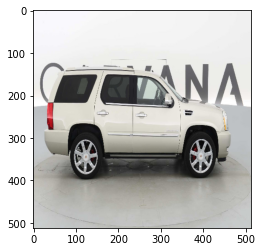

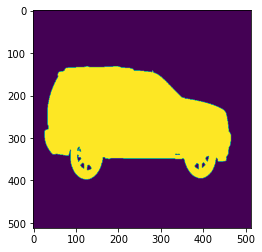

In [21]:
plt.imshow((img[0]).permute(1, 2, 0))
plt.show()
plt.imshow((mask[0][0]))
plt.show()

## Создание класса модели

In [22]:
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]

        return output

## Обучение модели

In [23]:
learning_rate = 0.001
epochs = 1

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [25]:
# Создание своей модели
Umodel = UNet(num_classes=1).to(device)

In [26]:
torch.__version__

'1.11.0.dev20210924'

In [27]:
# Создание модели из segmentation_models_pytorch
Umodel = smp.Unet('mobilenet_v2', 
                  classes=1, 
                  encoder_weights='imagenet').to(device)

In [28]:
optimizer = torch.optim.Adam(Umodel.parameters(), lr=learning_rate)

In [29]:
criterion = SoftDiceLoss()

In [30]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

1 epochs, 3808 total_steps per epoch


In [31]:
torch.cuda.empty_cache()

Train Epoch: 1, Loss: 0.06632487634817759
Spend time for 300 images: 35.28110933303833 sec


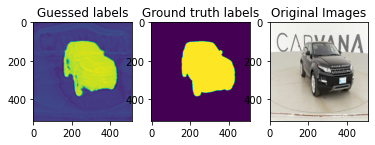

Train Epoch: 1, Loss: 0.024519192576408385
Spend time for 300 images: 34.61199331283569 sec


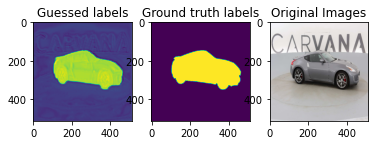

Train Epoch: 1, Loss: 0.011888458530108134
Spend time for 300 images: 34.51224637031555 sec


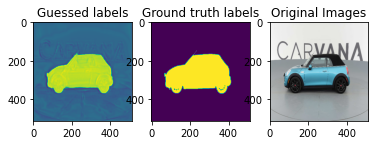

Train Epoch: 1, Loss: 0.011460706988970438
Spend time for 300 images: 34.37395763397217 sec


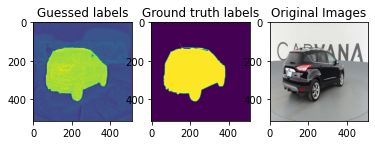

Train Epoch: 1, Loss: 0.018687431414922077
Spend time for 300 images: 33.847455739974976 sec


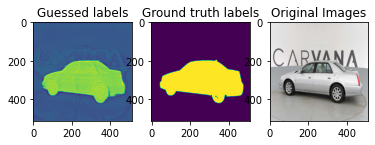

Train Epoch: 1, Loss: 0.011557541886965434
Spend time for 300 images: 33.81344294548035 sec


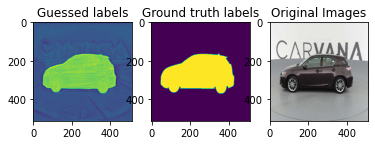

Train Epoch: 1, Loss: 0.008148965239524842
Spend time for 300 images: 34.24877429008484 sec


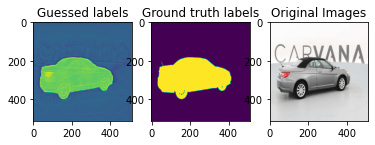

Train Epoch: 1, Loss: 0.007753193577130635
Spend time for 300 images: 34.026623249053955 sec


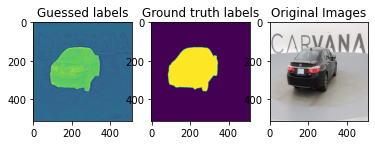

Train Epoch: 1, Loss: 0.007206210096677144
Spend time for 300 images: 34.296347856521606 sec


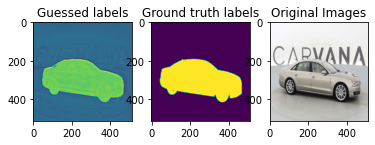

Train Epoch: 1, Loss: 0.012541822791099548
Spend time for 300 images: 34.23739409446716 sec


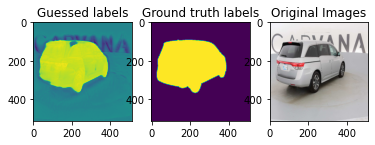

Train Epoch: 1, Loss: 0.009485475420951843
Spend time for 300 images: 34.67226791381836 sec


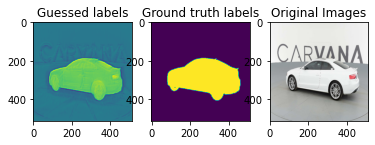

Train Epoch: 1, Loss: 0.007566699385643005
Spend time for 300 images: 34.82040476799011 sec


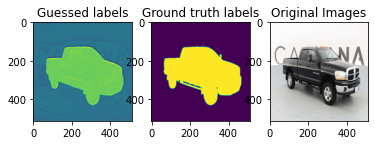

Epoch 1, loss:  0.015901661125802193


In [32]:
# Переходим в режим тренировки
Umodel.train()

#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time
from torch.autograd import Variable

# Полезная функция для детектирования аномалий в процессе обучения
#torch.autograd.set_detect_anomaly(True)

# запускаем главный тренировочный цикл
epoch_losses = []
for epoch in range(epochs):
    
    time1 = time.time()
    running_loss =0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = Variable(data), Variable(labels)        
        data = data.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()
        outputs = Umodel(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 300 == 299:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/300}')
            time2 = time.time()
            print(f'Spend time for 300 images: {time2-time1} sec')
            time1 = time.time()
            running_loss = 0.0

            f, axarr = plt.subplots(1,3)
            axarr[0].imshow(outputs[0].detach().cpu().numpy()[0, :, :])
            axarr[0].set_title('Guessed labels')

            axarr[1].imshow(labels[0].detach().cpu().numpy()[0, :, :])
            axarr[1].set_title('Ground truth labels')

            axarr[2].imshow(data[0].permute(1,2,0).detach().cpu().numpy()[:, :, :])
            axarr[2].set_title('Original Images')
            plt.show()

    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

## Валидация модели

In [36]:
def DICE(logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        outputs = torch.where(probs > 0.5, 1, 0)
        m1 = outputs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = score.sum() / num
        return score

In [38]:
# Сделать с другим размером батча, и без лишней интерполяции в даталоадере и сравнить время выполнения
# и качество работы
Umodel.eval()
valid_dices = []
valid_losses = []
for batch_idx, (data, labels) in enumerate(valid_data_loader):
        
        data, labels = Variable(data), Variable(labels)        
        data = data.cuda()
        labels = labels.cuda()
        outputs = Umodel(data)
        loss = criterion(outputs, labels)
        valid_losses.append(loss.item())
        
        outputs = F.interpolate(input=outputs, size=(1280, 1918), mode='nearest')
        # Нужно проверить не изменилась ли маска после интерполяции
        # Лучше избавиться от лишней интерполяции
        labels = F.interpolate(input=labels, size=(1280, 1918), mode='nearest')
        
        dice_coef = DICE(outputs, labels)
        dice_coef = dice_coef.cpu()
        valid_dices.append(dice_coef)


valid_loss = np.mean(valid_losses)
dice_coef  = np.mean(valid_dices)
print(f'DICE coef on validation: ', np.mean(dice_coef))
print(f'loss on validation: ', np.mean(valid_loss))

DICE coef on validation:  0.9924763
loss on validation:  0.007609328534454107


## Предсказание test (для submission на kaggle)

In [33]:
sample_submission = pd.read_csv('~/carvana_dataset/sample_submission.csv')

In [34]:
source = '/home/dima/carvana_dataset/test/test/'
destination = '/home/dima/carvana_dataset/test/predict/'

In [41]:
# Сделать методом класса, которому передается директория с картинками и sample_submission
# Возвращает измененный sample_submission для отправки на kaggle

In [35]:
sample_submission.head()

,img,rle_mask
0,0004d4463b50_01.jpg,1 1
1,0004d4463b50_02.jpg,1 1
2,0004d4463b50_03.jpg,1 1
3,0004d4463b50_04.jpg,1 1
4,0004d4463b50_05.jpg,1 1


In [160]:
class CustomDatasetForTest(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Получаем адреса RGB изображений 
        self.image_names = self.data_info.iloc[:,0]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        img = np.asarray(Image.open(source + self.image_names[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (H, W, 3) -> (1, H, W, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, H, W, 3) -> (1, 3, H, W)
        img = img.unsqueeze(0).permute(0,3,1,2)
        
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с HхW на 256х256
        # clamp не позволяет выйти за границы
        img = F.interpolate(input=img, size=(512, 512), align_corners=False, mode='bicubic').clamp(min=0, max=1)
        img = img.squeeze(0)
        
        image_name = self.image_names[index]
    
        return (index, img.float(), image_name)

    def __len__(self):
        return self.data_len

In [104]:
test_data = CustomDatasetForTest(sample_submission)
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=False)
loader = iter(test_data_loader)
index, img, img_name = loader.next()

In [120]:
# Заменить np на torch
def tensor_to_rle(tensor):
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    tensor = tensor.view(1, -1)
    tensor = tensor.squeeze(0)
    tensor[0] = 0
    tensor[-1] = 0
    rle = torch.where(tensor[1:] != tensor[:-1])[0] + 2
    rle[1::2] = rle[1::2] - rle[:-1:2]
    rle = rle.cpu().detach().numpy()
    rle_str = rle_to_string(rle)
    #rle_str = np.array_str(rle)
    return rle_str

In [121]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

In [122]:
%time
tensor_to_rle(img)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.53 µs


'2 165 168 74 243 97 341 72 414 63 478 3 482 1 484 29 679 1 754 1 852 1 925 1 989 1 993 1 995 1 1025 166 1192 74 1267 97 1365 72 1438 63 1502 3 1506 1 1508 29 1566 1 1569 130 1700 3 1704 74 1779 97 1877 72 1950 1 1952 59 2013 1 2015 1 2017 1 2019 1 2049 29 2079 2 2211 1 2290 1 2388 1 2463 1 2523 2 2526 1 2528 33 2590 1 2593 130 2724 78 2803 97 2901 74 2976 59 3037 1 3039 1 3073 29 3103 2 3231 4 3236 69 3306 8 3315 95 3411 1 3413 74 3488 59 3549 1 3551 1 3585 29 3615 2 3743 74 3818 104 3923 76 4000 63 4064 33 4126 1 4129 126 4329 1 4434 1 4511 1 4575 1 4609 153 4763 4 4826 1 4829 12 4842 104 4947 76 5024 48 5073 1 5075 12 5088 33 5274 1 5338 1 5341 12 5354 104 5459 76 5536 48 5585 1 5587 12 5600 33 5786 1 5850 1 5853 12 5866 104 5971 76 6048 48 6097 1 6099 12 6112 33 6264 1 6266 1 6294 1 6298 1 6362 1 6365 2 6377 1 6482 1 6557 1 6559 1 6608 1 6610 1 6623 1 6625 1 6657 119 6777 1 6779 27 6807 72 6994 1 7069 1 7137 1 7169 119 7289 1 7291 27 7319 72 7506 1 7581 1 7649 1 7681 119 7801 1 780

In [123]:
len(tensor_to_rle(img))

1802953

In [115]:
# Примерно 2 часа

In [110]:
Umodel.eval()
for batch_idx, (index, img, img_name)  in enumerate(test_data_loader):

    img = Variable(img)        
    img = img.cuda()
    pred_mask_logit = Umodel(img)
    pred_mask_logit = F.interpolate(input=pred_mask_logit, size=(1280, 1918), mode='nearest')
    pred_mask_logit_prob = torch.sigmoid(pred_mask_logit)
    pred_mask = torch.where(pred_mask_logit_prob > 0.5, 1, 0)
    pred_mask = pred_mask.squeeze(0)
    rle_str = tensor_to_rle(pred_mask)
    sample_submission['rle_mask'][index.item()] = rle_str

KeyboardInterrupt: 

## Предсказание на test

In [147]:
source

'/home/dima/carvana_dataset/test/test/'

In [148]:
destination

'/home/dima/carvana_dataset/test/predict/'

In [166]:
destination = '/home/dima/carvana_dataset/test/predict_small/'

In [155]:
test_df = {}
test_df['img_name'] = []

test_df['img_name'] = list(glob.glob(source + "/*"))
test_df = pd.DataFrame(test_df)

In [157]:
test_df['img_name'] = test_df['img_name'].apply(lambda x: x.split('/')[-1])

In [158]:
test_df.head()

,img_name
0,13857e9947b2_11.jpg
1,3ffa310d71ce_12.jpg
2,da5e65183070_02.jpg
3,bc202073bf8c_14.jpg
4,10e03166b5dc_13.jpg


In [159]:
test_df.shape

(100064, 1)

In [161]:
test_data = CustomDatasetForTest(test_df)
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=False)
loader = iter(test_data_loader)
index, img, img_name = loader.next()

In [162]:
index

tensor([0])

In [165]:
img_name[0]

'13857e9947b2_11.jpg'

In [164]:
img.shape

torch.Size([1, 3, 512, 512])

In [170]:
Umodel.eval()
for batch_idx, (index, img, img_name)  in enumerate(test_data_loader):
        
    img = Variable(img)        
    img = img.cuda()
    pred_mask_logit = Umodel(img)
    pred_mask_logit = F.interpolate(input=pred_mask_logit, size=(1280, 1918), mode='nearest')
    pred_mask_logit_prob = torch.sigmoid(pred_mask_logit)
    pred_mask = torch.where(pred_mask_logit_prob > 0.5, 1, 0)
    pred_mask = pred_mask.squeeze(0)
    pred_mask = pred_mask.cpu()
    pred_mask = pred_mask.numpy()
    pred_mask = pred_mask * 255.0
    PIL_image = Image.fromarray(pred_mask[0].astype('uint8'), 'L')
    PIL_image.save((destination+img_name[0]).split('.')[0]+'.gif')
    if batch_idx == 100:
        break

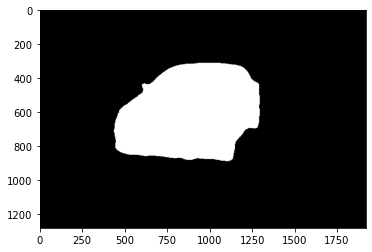

In [172]:
# Проверка 
mask = plt.imread('/home/dima/carvana_dataset/test/predict_small/0de9dc882416_02.gif')
#plt.imshow(mask[:,:,0])
plt.imshow(mask)
plt.show()

In [173]:
# В первых 3-х каналах одни и те же значения 
mask.shape

(1280, 1918, 4)

## Преобразование масок в rle

In [174]:
pred_masks_path = '/home/dima/carvana_dataset/test/predict_small'
data_masks = {}
data_masks['masks_path'] = []
data_masks['masks_path'] = list(glob.glob(pred_masks_path + "/*"))
data_masks = pd.DataFrame(data_masks)

In [180]:
data_masks.head()

,masks_path
0,/home/dima/carvana_dataset/test/predict_small/...
1,/home/dima/carvana_dataset/test/predict_small/...
2,/home/dima/carvana_dataset/test/predict_small/...
3,/home/dima/carvana_dataset/test/predict_small/...
4,/home/dima/carvana_dataset/test/predict_small/...


In [176]:
mask_addr = data_masks['masks_path'][0]

In [177]:
mask = Image.open(mask_addr).convert('LA') # преобразование в серый
mask = np.asarray(mask).astype('float')[:,:,0]
mask = mask/255.0

In [178]:
mask.shape

(1280, 1918)

In [184]:
def numpy_to_rle(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle_str = rle_to_string(runs)
    return rle_str

In [187]:
#numpy_to_rle(mask)

In [188]:
unique, counts = np.unique(mask, return_counts=True)

In [189]:
unique

array([0., 1.])

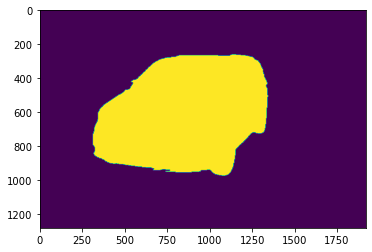

In [190]:
plt.imshow(mask)

In [191]:
def mask_to_rle(mask_addr):
    mask = Image.open(mask_addr).convert('LA') # преобразование в серый
    mask = np.asarray(mask).astype('float')[:,:,0]
    mask = mask/255.0
    mask_rle = numpy_to_rle(mask)
    return mask_rle

In [192]:
# 40 минут
data_masks['rle_mask'] = data_masks['masks_path'].apply(lambda x: mask_to_rle(x))

In [196]:
data_masks.head()

,masks_path,rle_mask
0,/home/dima/carvana_dataset/test/predict_small/...,499809 26 501727 26 503645 26 505556 60 507474...
1,/home/dima/carvana_dataset/test/predict_small/...,854429 41 856347 41 858265 41 860150 134 86206...
2,/home/dima/carvana_dataset/test/predict_small/...,720147 198 722065 198 723983 198 725886 243 72...
3,/home/dima/carvana_dataset/test/predict_small/...,649005 11 649072 23 650923 11 650990 23 652822...
4,/home/dima/carvana_dataset/test/predict_small/...,729759 105 731677 105 733595 105 735487 172 73...


In [198]:
sample_submission

,img,rle_mask
0,0004d4463b50_01.jpg,1 1
1,0004d4463b50_02.jpg,1 1
2,0004d4463b50_03.jpg,1 1
3,0004d4463b50_04.jpg,1 1
4,0004d4463b50_05.jpg,1 1
...,...,...
100059,fff341f26a19_12.jpg,1 1
100060,fff341f26a19_13.jpg,1 1
100061,fff341f26a19_14.jpg,1 1
100062,fff341f26a19_15.jpg,1 1
